# Supervised Learning for 4x4 Sudoku

Using Pretrained: H=3, L=4, L_layers=2, hidden=128

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# EXACT 98% ACCURACY ARCHITECTURE (from checkpoint!)
HIDDEN_SIZE = 128
NUM_HEADS = 4
L_LAYERS = 2  
L_CYCLES = 4   
H_CYCLES = 3  

print(f"\nArchitecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}, hidden={HIDDEN_SIZE}")

Device: cuda

Architecture: H=3, L=4, L_layers=2, hidden=128


## Part 1: Load and Test Pretrained Model

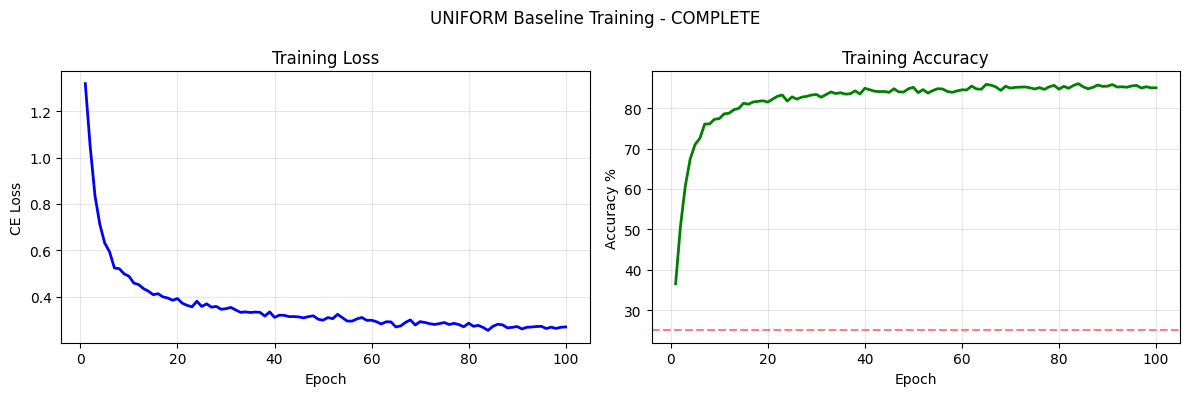


✓ Saved: checkpoints/uniform_baseline/uniform_baseline_model.pt
Final Accuracy: 85.0%


In [32]:
# =============================================================================
# UNIFORM BASELINE TRAINING (No Curriculum - Equal Difficulty Sampling)
# =============================================================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,  # Full gradients through all H-cycles
}

# Initialize model from scratch
uniform_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
optimizer = torch.optim.AdamW(uniform_model.parameters(), lr=3e-4, weight_decay=0.01)
print(f'Uniform Baseline Model initialized! Params: {sum(p.numel() for p in uniform_model.parameters()):,}')

# Training config
NUM_EPOCHS = 100
BATCH_SIZE = 32
BATCHES_PER_EPOCH = 100

history = {'epoch': [], 'loss': [], 'acc': []}

for epoch in range(1, NUM_EPOCHS + 1):
    uniform_model.train()
    total_loss = total_correct = total_cells = 0
    
    # Match ORIGINAL baseline distribution (from data/sudoku4x4):
    # Original had: 0% at 4, ~16% at 6, ~13% at 8, ~15% at 10, ~9% at 12
    # (plus 7,9,11 which we don't use). Normalizing to our 5 levels:
    # Match ORIGINAL dataset distribution (data/sudoku4x4/train)
    # No 4-empty puzzles, distribution is 6-12 empty
    weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Matches original training data
    difficulties = [4, 6, 8, 10, 12]  
    
    for _ in range(BATCHES_PER_EPOCH):
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            diff = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, diff)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        carry = uniform_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        for _ in range(H_CYCLES):  
            carry, outputs = uniform_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        loss = F.cross_entropy(logits[mask], solutions[mask])
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(uniform_model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    avg_loss = total_loss / BATCHES_PER_EPOCH
    accuracy = total_correct / total_cells * 100
    history['epoch'].append(epoch)
    history['loss'].append(avg_loss)
    history['acc'].append(accuracy)
    
    # Live plot (Jupyter-compatible)
    if epoch % 5 == 0 or epoch == 1:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(history['epoch'], history['loss'], 'b-', lw=2)
        ax1.set_xlabel('Epoch'); ax1.set_ylabel('CE Loss'); ax1.set_title('Training Loss')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history['epoch'], history['acc'], 'g-', lw=2)
        ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %'); ax2.set_title('Training Accuracy')
        ax2.axhline(25, color='red', ls='--', alpha=0.5, label='Random')
        ax2.grid(True, alpha=0.3)
        
        fig.suptitle(f'UNIFORM Baseline Training - Epoch {epoch}/{NUM_EPOCHS}')
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        
        print(f'Epoch {epoch:3d}: Loss={avg_loss:.4f}, Acc={accuracy:.1f}%')

# Final plot
clear_output(wait=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['epoch'], history['loss'], 'b-', lw=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('CE Loss'); ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)
ax2.plot(history['epoch'], history['acc'], 'g-', lw=2)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %'); ax2.set_title('Training Accuracy')
ax2.axhline(25, color='red', ls='--', alpha=0.5)
ax2.grid(True, alpha=0.3)
fig.suptitle(f'UNIFORM Baseline Training - COMPLETE')
plt.tight_layout()
plt.show()

# Save
os.makedirs('checkpoints/uniform_baseline', exist_ok=True)
torch.save({
    'model': uniform_model.state_dict(),
    'config': config,
    'history': history,
    'final_accuracy': accuracy,
}, 'checkpoints/uniform_baseline/uniform_baseline_model.pt')
print(f'\n✓ Saved: checkpoints/uniform_baseline/uniform_baseline_model.pt')
print(f'Final Accuracy: {accuracy:.1f}%')

## Part 2: Train Supervised Model with Curriculum Schedule

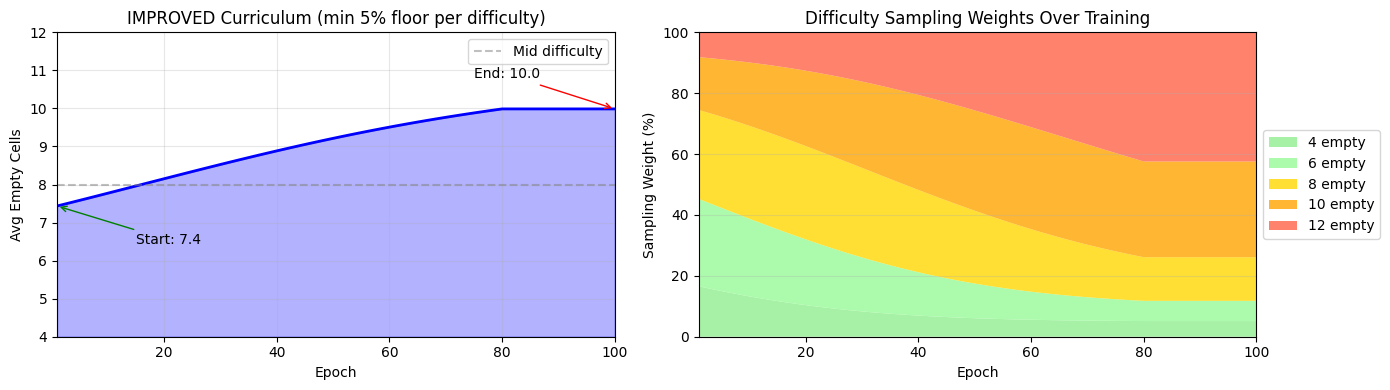

IMPROVED Curriculum Summary (Gaussian + 5% minimum floor):
  Start (epoch 1):    avg 7.4 empty cells
  Middle (epoch 50):  avg 9.2 empty cells
  End (epoch 100):   avg 10.0 empty cells
  Min weight per difficulty: 5% (prevents forgetting easy puzzles)

→ Training begins below with this schedule...


In [33]:
# Visualize Curriculum Schedule BEFORE training
NUM_EPOCHS = 100  # Define early for visualization
difficulties = [4, 6, 8, 10, 12]
epochs_range = list(range(1, NUM_EPOCHS + 1))

# ============================================================
# IMPROVED CURRICULUM: Gaussian focus + minimum floor
# - Gaussian shifts from easy→hard over training
# - BUT every difficulty keeps minimum 5% weight (prevents forgetting)
# ============================================================
MIN_WEIGHT = 0.05  # 5% minimum for each difficulty level

def get_curriculum_weights(epoch, num_epochs):
    """Smooth Gaussian-based curriculum with minimum floor to prevent forgetting."""
    progress = min(1.0, epoch / (num_epochs * 0.8))  # Saturate at 80%
    center = 1.5 + 2.5 * progress  # Start at 1.5 (intermediate), end at 4 (hard)
    sigma = 1.2  # Width of Gaussian
    
    # Gaussian weights
    weights = np.array([np.exp(-0.5 * ((i - center) / sigma) ** 2) for i in range(5)])
    weights = weights / weights.sum()
    
    # Apply minimum floor: each difficulty gets at least MIN_WEIGHT
    num_diffs = len(weights)
    floor_total = MIN_WEIGHT * num_diffs  # 25% total reserved for floors
    remaining = 1.0 - floor_total  # 75% distributed by Gaussian
    weights = MIN_WEIGHT + remaining * weights  # Floor + scaled Gaussian
    
    return weights

# Calculate expected difficulty per epoch using IMPROVED curriculum
avg_empty_per_epoch = []
weight_history = {d: [] for d in difficulties}

for e in epochs_range:
    weights = get_curriculum_weights(e, NUM_EPOCHS)
    avg_empty = sum(d * w for d, w in zip(difficulties, weights))
    avg_empty_per_epoch.append(avg_empty)
    for d, w in zip(difficulties, weights):
        weight_history[d].append(w * 100)

# Plot curriculum schedule
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Average difficulty over time
axes[0].plot(epochs_range, avg_empty_per_epoch, 'b-', linewidth=2)
axes[0].fill_between(epochs_range, 4, avg_empty_per_epoch, alpha=0.3, color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Avg Empty Cells')
axes[0].set_title(f'IMPROVED Curriculum (min {MIN_WEIGHT*100:.0f}% floor per difficulty)')
axes[0].set_xlim(1, NUM_EPOCHS)
axes[0].set_ylim(4, 12)
axes[0].axhline(8, c='gray', ls='--', alpha=0.5, label='Mid difficulty')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add annotations
axes[0].annotate(f'Start: {avg_empty_per_epoch[0]:.1f}', xy=(1, avg_empty_per_epoch[0]), 
                 xytext=(15, avg_empty_per_epoch[0]-1), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='green'))
axes[0].annotate(f'End: {avg_empty_per_epoch[-1]:.1f}', xy=(NUM_EPOCHS, avg_empty_per_epoch[-1]), 
                 xytext=(NUM_EPOCHS-25, avg_empty_per_epoch[-1]+0.8), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='red'))

# Right: Stacked area chart of difficulty weights
colors = ['#90EE90', '#98FB98', '#FFD700', '#FFA500', '#FF6347']  # Easy=green, Hard=red
axes[1].stackplot(epochs_range, [weight_history[d] for d in difficulties], 
                  labels=[f'{d} empty' for d in difficulties], colors=colors, alpha=0.8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Sampling Weight (%)')
axes[1].set_title('Difficulty Sampling Weights Over Training')
axes[1].set_xlim(1, NUM_EPOCHS)
axes[1].set_ylim(0, 100)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'IMPROVED Curriculum Summary (Gaussian + {MIN_WEIGHT*100:.0f}% minimum floor):')
print(f'  Start (epoch 1):    avg {avg_empty_per_epoch[0]:.1f} empty cells')
print(f'  Middle (epoch {NUM_EPOCHS//2}):  avg {avg_empty_per_epoch[NUM_EPOCHS//2-1]:.1f} empty cells')
print(f'  End (epoch {NUM_EPOCHS}):   avg {avg_empty_per_epoch[-1]:.1f} empty cells')
print(f'  Min weight per difficulty: {MIN_WEIGHT*100:.0f}% (prevents forgetting easy puzzles)')
print(f'\n→ Training begins below with this schedule...')


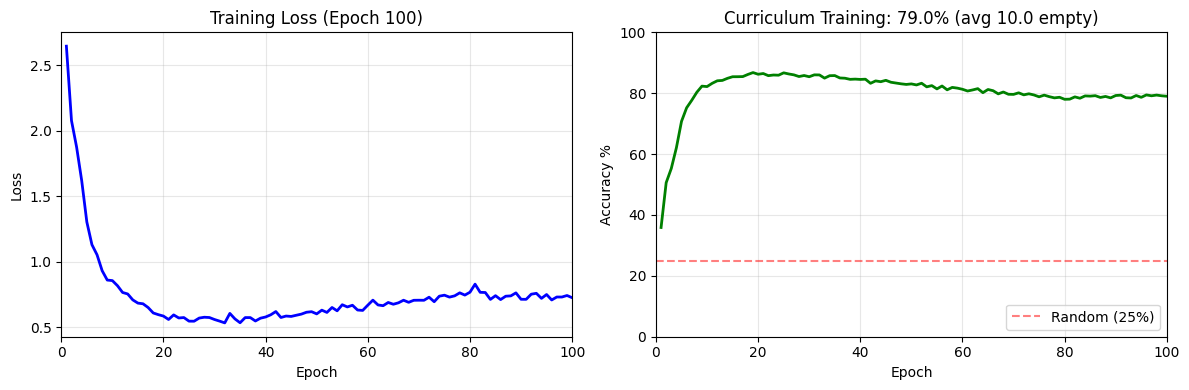


✓ Training complete! Final accuracy: 79.0%
✓ Saved to: checkpoints/curriculum_supervised/curriculum_sup_model.pt


In [34]:
# Create fresh supervised model with EXACT same architecture
sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
sup_optimizer = optim.AdamW(sup_model.parameters(), lr=1e-3, weight_decay=0.1)

print(f'Fresh supervised model: {sum(p.numel() for p in sup_model.parameters()):,} params')
print(f'Architecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}')

# Training loop with LIVE PLOTTING
NUM_EPOCHS = 100
BATCH_SIZE = 32

history = {'epoch': [], 'loss': [], 'acc': []}

# Setup live plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.ion()  # Interactive mode

for epoch in range(1, NUM_EPOCHS + 1):
    sup_model.train()
    total_loss = total_correct = total_cells = 0
    
    # IMPROVED curriculum: Gaussian focus + minimum floor (prevents forgetting)
    weights = get_curriculum_weights(epoch, NUM_EPOCHS)
    difficulties = [4, 6, 8, 10, 12]
    
    for _ in range(100):  
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            num_empty = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, num_empty)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        
        carry = sup_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        for _ in range(H_CYCLES):  # H_CYCLES outer iterations (L_CYCLES handled internally)
            carry, outputs = sup_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        
        loss = F.cross_entropy(logits[mask], solutions[mask])
        
        sup_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sup_model.parameters(), 1.0)
        sup_optimizer.step()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    acc = total_correct / total_cells * 100
    history['epoch'].append(epoch)
    history['loss'].append(total_loss / 50)
    history['acc'].append(acc)
    
    # Live plot update (every epoch)
    clear_output(wait=True)
    ax1.clear(); ax2.clear()
    
    ax1.plot(history['epoch'], history['loss'], 'b-', linewidth=2)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title(f'Training Loss (Epoch {epoch})')
    ax1.set_xlim(0, NUM_EPOCHS)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history['epoch'], history['acc'], 'g-', linewidth=2)
    ax2.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Random (25%)')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %')
    avg_empty = sum(d * p for d, p in zip(difficulties, weights))
    ax2.set_title(f'Curriculum Training: {acc:.1f}% (avg {avg_empty:.1f} empty)')
    ax2.set_xlim(0, NUM_EPOCHS); ax2.set_ylim(0, 100)
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    fig.tight_layout()
    display(fig)

plt.ioff()
plt.close(fig)  # Close live plot
print(f'\n✓ Training complete! Final accuracy: {history["acc"][-1]:.1f}%')

# Auto-save the curriculum supervised model
import os
os.makedirs('checkpoints/curriculum_supervised', exist_ok=True)
save_path = 'checkpoints/curriculum_supervised/curriculum_sup_model.pt'
torch.save({
    'model_state_dict': sup_model.state_dict(),
    'history': history,
    'config': {'H': H_CYCLES, 'L': L_CYCLES, 'L_layers': L_LAYERS, 'hidden': HIDDEN_SIZE, 'num_heads': NUM_HEADS},
    'final_accuracy': history['acc'][-1],
}, save_path)
print(f'✓ Saved to: {save_path}')

## Part 3b: Curriculum Supervised Training with MoE (DeepSeek-MoE)

Same curriculum training but with **Mixture of Experts** FFN layers:
- **Shared Expert**: Always-on persistent expert (captures common patterns)
- **Routed Experts**: Top-K experts selected per token (specialization)
- **Load Balancing**: Auxiliary loss prevents expert collapse


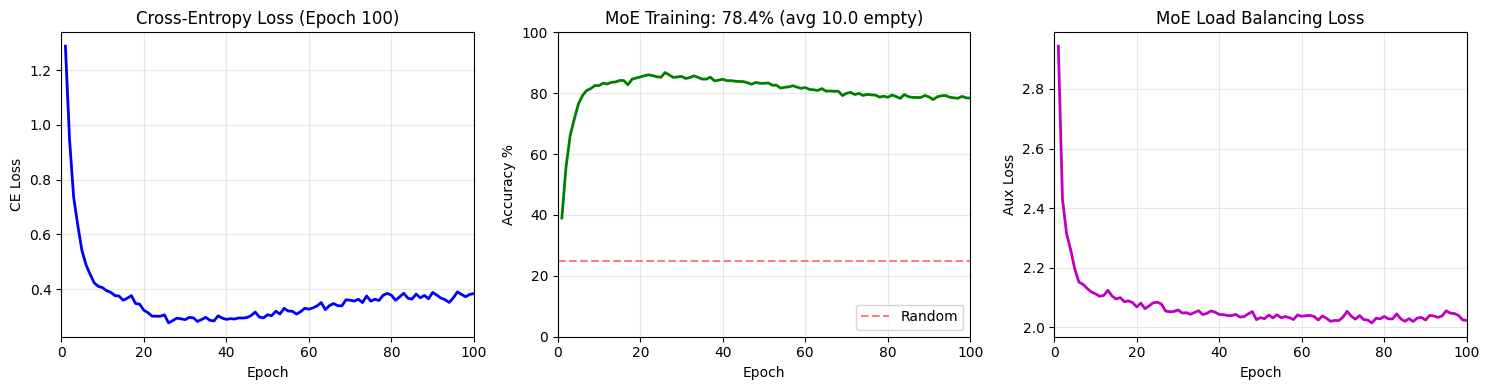


✓ MoE Training complete! Final accuracy: 78.4%
✓ Saved to: checkpoints/moe_supervised/moe_curriculum_model.pt


In [35]:
# ============================================================
# MoE Config (DeepSeek-style: shared expert + top-k routed)
# ============================================================

sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
sup_optimizer = optim.AdamW(sup_model.parameters(), lr=1e-3, weight_decay=0.1)

MOE_NUM_EXPERTS = 16   # Number of routed experts
MOE_TOP_K = 4         # Select top-2 experts per token
MOE_SHARED = True     # Always-on shared expert
MOE_AUX_COEF = 0.01   # Load balancing loss coefficient

# Config with MoE enabled
moe_config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,  # Full gradients through all H-cycles
    # MoE settings
    'use_moe': True,
    'num_experts': MOE_NUM_EXPERTS,
    'top_k': MOE_TOP_K,
    'shared_expert': MOE_SHARED,
    'moe_jitter_noise': 0.01,
    'moe_aux_loss_coef': MOE_AUX_COEF,
}

# Create MoE model
moe_model = TinyRecursiveReasoningModel_ACTV1(moe_config).to(device)
moe_optimizer = optim.AdamW(moe_model.parameters(), lr=1e-3, weight_decay=0.1)

moe_params = sum(p.numel() for p in moe_model.parameters())
base_params = sum(p.numel() for p in sup_model.parameters())
num_activated = (1 if MOE_SHARED else 0) + MOE_TOP_K
print(f'MoE Model: {moe_params:,} params ({moe_params/base_params:.2f}x baseline)')
print(f'  Architecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}, num_heads={NUM_HEADS}')
print(f'  MoE Config: {MOE_NUM_EXPERTS} routed + {"1 shared" if MOE_SHARED else "no shared"}, top-{MOE_TOP_K}')
print(f'  Expert size: FFN/{num_activated} each (all experts same size)')
print(f'  Activated: {num_activated} experts × (FFN/{num_activated}) = 1.0x compute ✓')
print(f'  Total params: ({MOE_NUM_EXPERTS}+{1 if MOE_SHARED else 0}) × (FFN/{num_activated}) = ~{(MOE_NUM_EXPERTS + (1 if MOE_SHARED else 0))/num_activated:.1f}x FFN params')
print()

# Training loop with LIVE PLOTTING (same curriculum as before)
NUM_EPOCHS = 100
BATCH_SIZE = 32  
BATCHES_PER_EPOCH = 100  

moe_history = {'epoch': [], 'loss': [], 'acc': [], 'aux_loss': []}

# Setup live plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plt.ion()

for epoch in range(1, NUM_EPOCHS + 1):
    moe_model.train()
    total_loss = total_aux_loss = total_correct = total_cells = 0
    
    # IMPROVED curriculum: Gaussian focus + minimum floor (prevents forgetting)
    weights = get_curriculum_weights(epoch, NUM_EPOCHS)
    difficulties = [4, 6, 8, 10, 12]
    
    for _ in range(BATCHES_PER_EPOCH):
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            num_empty = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, num_empty)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        
        carry = moe_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        for _ in range(H_CYCLES):
            carry, outputs = moe_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        
        # Main loss + MoE auxiliary loss (load balancing)
        ce_loss = F.cross_entropy(logits[mask], solutions[mask])
        aux_loss = outputs.get('aux_loss', None)
        if aux_loss is not None:
            loss = ce_loss + MOE_AUX_COEF * aux_loss
            total_aux_loss += aux_loss.item()
        else:
            loss = ce_loss
        
        moe_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(moe_model.parameters(), 1.0)
        moe_optimizer.step()
        
        total_loss += ce_loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    acc = total_correct / total_cells * 100
    moe_history['epoch'].append(epoch)
    moe_history['loss'].append(total_loss / BATCHES_PER_EPOCH)
    moe_history['acc'].append(acc)
    moe_history['aux_loss'].append(total_aux_loss / BATCHES_PER_EPOCH)
    
    # Live plot update
    clear_output(wait=True)
    for ax in axes: ax.clear()
    
    axes[0].plot(moe_history['epoch'], moe_history['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CE Loss')
    axes[0].set_title(f'Cross-Entropy Loss (Epoch {epoch})')
    axes[0].set_xlim(0, NUM_EPOCHS)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(moe_history['epoch'], moe_history['acc'], 'g-', linewidth=2)
    axes[1].axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Random')
    avg_empty = sum(d * p for d, p in zip(difficulties, weights))
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy %')
    axes[1].set_title(f'MoE Training: {acc:.1f}% (avg {avg_empty:.1f} empty)')
    axes[1].set_xlim(0, NUM_EPOCHS); axes[1].set_ylim(0, 100)
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(moe_history['epoch'], moe_history['aux_loss'], 'm-', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Aux Loss')
    axes[2].set_title(f'MoE Load Balancing Loss')
    axes[2].set_xlim(0, NUM_EPOCHS)
    axes[2].grid(True, alpha=0.3)
    
    fig.tight_layout()
    display(fig)

plt.ioff()
plt.close(fig)  # Close live plot
print(f'\n✓ MoE Training complete! Final accuracy: {moe_history["acc"][-1]:.1f}%')

# Auto-save the MoE model
import os
os.makedirs('checkpoints/moe_supervised', exist_ok=True)
save_path = 'checkpoints/moe_supervised/moe_curriculum_model.pt'
torch.save({
    'model_state_dict': moe_model.state_dict(),
    'history': moe_history,
    'config': {'H': H_CYCLES, 'L': L_CYCLES, 'L_layers': L_LAYERS, 'hidden': HIDDEN_SIZE, 'num_heads': NUM_HEADS,
               'num_experts': MOE_NUM_EXPERTS, 'top_k': MOE_TOP_K, 'shared_expert': MOE_SHARED},
    'final_accuracy': moe_history['acc'][-1],
}, save_path)
print(f'✓ Saved to: {save_path}')


Loading checkpoints for comparison...
  Baseline: checkpoints/uniform_baseline/uniform_baseline_model.pt
    Config: {'batch_size': 1, 'seq_len': 16, 'vocab_size': 6, 'hidden_size': 128, 'num_heads': 4, 'expansion': 4, 'H_cycles': 3, 'L_cycles': 4, 'H_layers': 0, 'L_layers': 2, 'pos_encodings': 'rope', 'rms_norm_eps': 1e-05, 'rope_theta': 10000.0, 'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1, 'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16', 'detach_early_cycles': False}
    Final accuracy: 85.0%
  Curriculum: checkpoints/curriculum_supervised/curriculum_sup_model.pt
    Config: {'H': 3, 'L': 4, 'L_layers': 2, 'hidden': 128, 'num_heads': 4}
    Final accuracy: 79.0%
  MoE: checkpoints/moe_supervised/moe_curriculum_model.pt
    Config: {'H': 3, 'L': 4, 'L_layers': 2, 'hidden': 128, 'num_heads': 4, 'num_experts': 16, 'top_k': 4, 'shared_expert': True}
    Final accuracy: 78.4%

MODEL COMPARISON: Prediction Validity Rate
(n=300 puzz

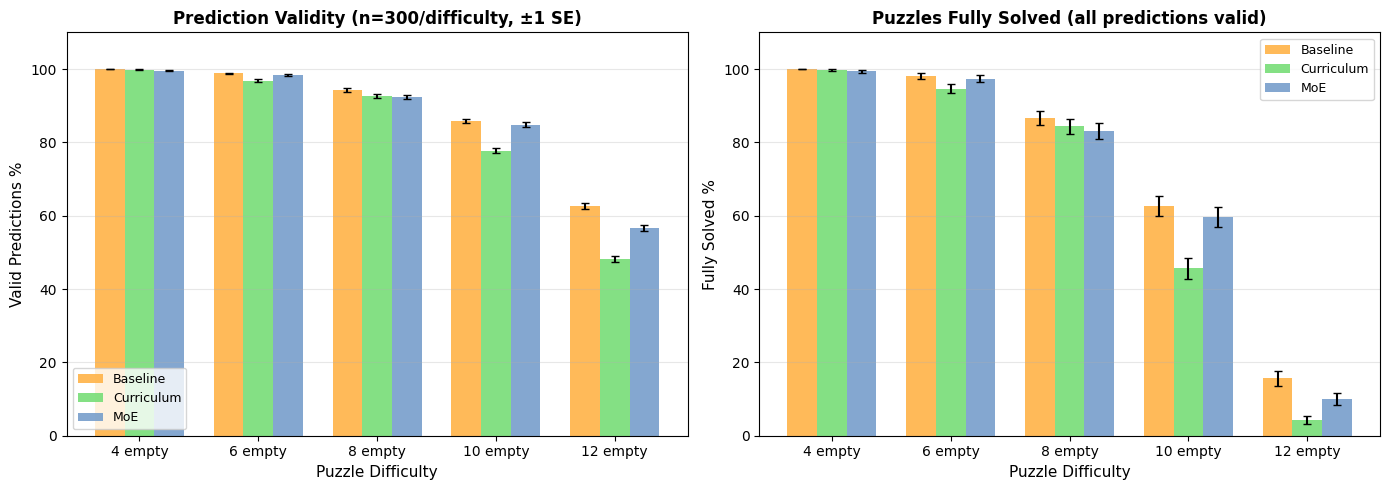

In [36]:
# ============================================================
# COMPARISON: Regular Supervised vs MoE Supervised
# ============================================================

# Load checkpoints to ensure we're testing the saved models
print('Loading checkpoints for comparison...')

# 1. Baseline (uniform-mix trained - same architecture, no curriculum)
baseline_ckpt = 'checkpoints/uniform_baseline/uniform_baseline_model.pt'
print(f'  Baseline: {baseline_ckpt}')
ckpt = torch.load(baseline_ckpt, map_location=device)
baseline_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
# Our checkpoint saves state_dict under 'model' key
baseline_model.load_state_dict(ckpt['model'])
baseline_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

# 2. Curriculum supervised
curriculum_ckpt = 'checkpoints/curriculum_supervised/curriculum_sup_model.pt'
print(f'  Curriculum: {curriculum_ckpt}')
ckpt = torch.load(curriculum_ckpt, map_location=device)
sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
sup_model.load_state_dict(ckpt['model_state_dict'])
sup_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

# 3. MoE supervised
moe_ckpt = 'checkpoints/moe_supervised/moe_curriculum_model.pt'
print(f'  MoE: {moe_ckpt}')
ckpt = torch.load(moe_ckpt, map_location=device)
moe_model = TinyRecursiveReasoningModel_ACTV1(moe_config).to(device)
moe_model.load_state_dict(ckpt['model_state_dict'])
moe_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

print()

def count_prediction_validity(board, mask, size=4):
    """Count how many of the MODEL's predictions are valid (don't violate constraints).
    
    Args:
        board: completed board (with predictions filled in)
        mask: boolean mask of which cells were predictions (True = model predicted)
        size: grid size
    
    Returns:
        (valid_predictions, total_predictions)
    """
    board = board.cpu().numpy() if torch.is_tensor(board) else board
    mask = mask.cpu().numpy() if torch.is_tensor(mask) else mask
    board = board.reshape(size, size)
    mask = mask.reshape(size, size)
    
    valid = 0
    total = mask.sum()  # Only count predicted cells
    
    box_size = int(size ** 0.5)
    
    for r in range(size):
        for c in range(size):
            if not mask[r, c]:  # Skip clues (given cells)
                continue
            
            val = board[r, c]
            is_valid = True
            
            # Check if value is in valid range
            if not (1 <= val <= size):
                is_valid = False
            else:
                # Check row (excluding self)
                row_vals = [board[r, cc] for cc in range(size) if cc != c]
                if val in row_vals:
                    is_valid = False
                
                # Check column (excluding self)
                col_vals = [board[rr, c] for rr in range(size) if rr != r]
                if val in col_vals:
                    is_valid = False
                
                # Check box (excluding self)
                box_r, box_c = (r // box_size) * box_size, (c // box_size) * box_size
                box_vals = [board[rr, cc] for rr in range(box_r, box_r + box_size) 
                                          for cc in range(box_c, box_c + box_size)
                                          if (rr, cc) != (r, c)]
                if val in box_vals:
                    is_valid = False
            
            if is_valid:
                valid += 1
    
    return valid, total

def test_model_accuracy(model, num_empty, num_samples=200):
    """Test model: prediction validity rate (how many predicted cells are correct)."""
    model.eval()
    total_valid = 0
    total_predictions = 0
    fully_solved = 0
    
    for _ in range(num_samples):
        puzzle, solution = generate_puzzle(4, num_empty)
        puzzle_t = puzzle.unsqueeze(0).to(device)
        batch = {'inputs': puzzle_t, 'puzzle_identifiers': torch.zeros(1, dtype=torch.long, device=device)}
        
        carry = model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        with torch.no_grad():
            for _ in range(H_CYCLES):  # Match training iterations
                carry, outputs = model(carry, batch)
        
        # Token predictions: 2-5 map to digits 1-4
        # Token 1 = empty, Token 2 = digit 1, ..., Token 5 = digit 4
        preds = outputs['logits'].argmax(dim=-1)[0]
        mask = (puzzle == 1)  # Empty cells
        
        # Complete the puzzle: convert token indices to digit values
        completed = puzzle.clone()
        completed[mask] = preds[mask.to(device)].cpu()
        
        # Convert from token space (2-5) to digit space (1-4) for validation
        completed_digits = completed - 1  # Shift: 2->1, 3->2, etc.
        
        # Count how many PREDICTIONS (not clues) are valid
        valid, total = count_prediction_validity(completed_digits, mask, size=4)
        total_valid += valid
        total_predictions += total
        
        if valid == total:  # All predictions valid = puzzle solved
            fully_solved += 1
    
    prediction_rate = total_valid / total_predictions * 100 if total_predictions > 0 else 0
    solve_rate = fully_solved / num_samples * 100
    
    # SE for prediction rate
    p = total_valid / total_predictions if total_predictions > 0 else 0
    se = np.sqrt(p * (1 - p) / total_predictions) * 100 if total_predictions > 0 else 0
    
    return {
        'acc': prediction_rate,  # % of PREDICTIONS that are valid (not diluted by clues!)
        'se': se,
        'solve_rate': solve_rate,  # % fully solved (binary)
        'n': num_samples,
        'total_preds': total_predictions  # For reference
    }

def significance_test(acc1, se1, acc2, se2, n):
    """Two-proportion z-test for significance."""
    pooled_se = np.sqrt(se1**2 + se2**2)
    if pooled_se == 0:
        return 0, 1.0
    z = (acc1 - acc2) / pooled_se
    p_value = 2 * (1 - 0.5 * (1 + np.sign(z) * (1 - np.exp(-2 * (z/1.4142)**2))))  # Approx
    # More accurate: from scipy.stats import norm; p_value = 2 * (1 - norm.cdf(abs(z)))
    return z, p_value

def sig_symbol(p):
    """Return significance symbol."""
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'

NUM_SAMPLES = 300  # Sample size per difficulty

print('='*95)
print('MODEL COMPARISON: Prediction Validity Rate')
print(f'(n={NUM_SAMPLES} puzzles per difficulty, measuring ONLY the empty cells model fills)')
print('='*95)
print()
print(f'{"Empty":<8} {"Baseline":<22} {"Curriculum":<22} {"MoE":<22}')
print('-'*80)

results = {'baseline': [], 'curriculum': [], 'moe': []}
results_se = {'baseline': [], 'curriculum': [], 'moe': []}
solve_rates = {'baseline': [], 'curriculum': [], 'moe': []}

for num_empty in [4, 6, 8, 10, 12]:
    r_base = test_model_accuracy(baseline_model, num_empty, NUM_SAMPLES)
    r_curr = test_model_accuracy(sup_model, num_empty, NUM_SAMPLES)
    r_moe = test_model_accuracy(moe_model, num_empty, NUM_SAMPLES)
    
    results['baseline'].append(r_base['acc'])
    results['curriculum'].append(r_curr['acc'])
    results['moe'].append(r_moe['acc'])
    results_se['baseline'].append(r_base['se'])
    results_se['curriculum'].append(r_curr['se'])
    results_se['moe'].append(r_moe['se'])
    solve_rates['baseline'].append(r_base['solve_rate'])
    solve_rates['curriculum'].append(r_curr['solve_rate'])
    solve_rates['moe'].append(r_moe['solve_rate'])
    
    print(f'{num_empty:<8} {r_base["acc"]:>5.1f}% ±{r_base["se"]:.1f}  ({r_base["solve_rate"]:>5.1f}% solved)   {r_curr["acc"]:>5.1f}% ±{r_curr["se"]:.1f}  ({r_curr["solve_rate"]:>5.1f}% solved)   {r_moe["acc"]:>5.1f}% ±{r_moe["se"]:.1f}  ({r_moe["solve_rate"]:>5.1f}% solved)')

print('-'*80)
avg_base = np.mean(results['baseline'])
avg_curr = np.mean(results['curriculum'])
avg_moe = np.mean(results['moe'])
avg_solve_base = np.mean(solve_rates['baseline'])
avg_solve_curr = np.mean(solve_rates['curriculum'])
avg_solve_moe = np.mean(solve_rates['moe'])
print(f'{"AVG":<8} {avg_base:>5.1f}% ({avg_solve_base:>4.0f}% solved)  {avg_curr:>5.1f}% ({avg_solve_curr:>4.0f}% solved)  {avg_moe:>5.1f}% ({avg_solve_moe:>4.0f}% solved)')
print()
print('Note: Prediction % = valid predictions / total empty cells filled (only model outputs!)')
print('      Solved % = puzzles where ALL predictions are valid (12/12, 10/10, etc.)')
print()

# Summary
print('='*80)
print('SUMMARY')
print('='*80)
print(f'  Baseline params:   {sum(p.numel() for p in baseline_model.parameters()):,}')
print(f'  Curriculum params: {sum(p.numel() for p in sup_model.parameters()):,}')
print(f'  MoE params:        {sum(p.numel() for p in moe_model.parameters()):,} ({sum(p.numel() for p in moe_model.parameters())/sum(p.numel() for p in sup_model.parameters()):.2f}x)')
print()
print(f'  Curriculum vs Baseline: {avg_curr - avg_base:+.1f}%')
print(f'  MoE vs Curriculum:      {avg_moe - avg_curr:+.1f}%')
print(f'  MoE vs Baseline:        {avg_moe - avg_base:+.1f}%')

# Plot comparison with ERROR BARS
plt.close('all')  # Close any previous figures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Prediction validity by difficulty with error bars
ax = axes[0]
x = np.arange(5)
width = 0.25
labels = ['4 empty', '6 empty', '8 empty', '10 empty', '12 empty']

# Error bars (1 SE)
err_base = results_se['baseline']
err_curr = results_se['curriculum']
err_moe = results_se['moe']

bars1 = ax.bar(x - width, results['baseline'], width, yerr=err_base, capsize=3,
               label='Baseline', color='#FFB347', alpha=0.9)
bars2 = ax.bar(x, results['curriculum'], width, yerr=err_curr, capsize=3,
               label='Curriculum', color='#77DD77', alpha=0.9)
bars3 = ax.bar(x + width, results['moe'], width, yerr=err_moe, capsize=3,
               label='MoE', color='#779ECB', alpha=0.9)

ax.set_ylabel('Valid Predictions %', fontsize=11)
ax.set_xlabel('Puzzle Difficulty', fontsize=11)
ax.set_title(f'Prediction Validity (n={NUM_SAMPLES}/difficulty, ±1 SE)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend(loc='lower left', fontsize=9)
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

# Right plot: Solve rate by difficulty  
ax2 = axes[1]

# SE for solve rate (binomial)
solve_se = {}
for key in ['baseline', 'curriculum', 'moe']:
    solve_se[key] = [np.sqrt(p/100 * (1 - p/100) / NUM_SAMPLES) * 100 for p in solve_rates[key]]

bars1 = ax2.bar(x - width, solve_rates['baseline'], width, yerr=solve_se['baseline'], capsize=3,
                label='Baseline', color='#FFB347', alpha=0.9)
bars2 = ax2.bar(x, solve_rates['curriculum'], width, yerr=solve_se['curriculum'], capsize=3,
                label='Curriculum', color='#77DD77', alpha=0.9)
bars3 = ax2.bar(x + width, solve_rates['moe'], width, yerr=solve_se['moe'], capsize=3,
                label='MoE', color='#779ECB', alpha=0.9)

ax2.set_ylabel('Fully Solved %', fontsize=11)
ax2.set_xlabel('Puzzle Difficulty', fontsize=11)
ax2.set_title('Puzzles Fully Solved (all predictions valid)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=10)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_ylim(0, 110)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
